In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

2023-12-05 21:17:54.915899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
flights = pd.read_csv('Combined_Flights_2022.csv.zip')

In [3]:
flights['FlightDate'] = pd.to_datetime(flights['FlightDate'])

# EDA

Flight Status Dataset

In [4]:
flights.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,-10.0,...,1140.0,1220.0,8.0,1245,-17.0,0.0,-2.0,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,-4.0,...,744.0,839.0,9.0,849,-1.0,0.0,-1.0,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,-15.0,...,1535.0,1622.0,14.0,1639,-3.0,0.0,-1.0,1600-1659,2,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,1430.0,0.0,-5.0,...,1446.0,1543.0,4.0,1605,-18.0,0.0,-2.0,1600-1659,2,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,1135.0,0.0,0.0,...,1154.0,1243.0,8.0,1245,6.0,0.0,0.0,1200-1259,2,0


Data types of each feature

In [5]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078318 entries, 0 to 4078317
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[ns]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                     

Summary statistics for each numerical feature

In [6]:
flights.describe().T

,count,mean,min,25%,50%,75%,max,std
FlightDate,4078318,2022-04-18 12:10:43.903097600,2022-01-01 00:00:00,2022-02-25 00:00:00,2022-04-19 00:00:00,2022-06-11 00:00:00,2022-07-31 00:00:00,NaN
CRSDepTime,4078318.0,1329.586665,1.0,914.0,1320.0,1735.0,2359.0,490.480125
DepTime,3957885.0,1334.373931,1.0,917.0,1325.0,1744.0,2400.0,505.621933
DepDelayMinutes,3957823.0,16.014938,0.0,0.0,0.0,11.0,7223.0,52.314976
DepDelay,3957823.0,13.090487,-78.0,-5.0,-2.0,11.0,7223.0,53.320163
ArrTime,3954079.0,1457.886018,1.0,1046.0,1500.0,1914.0,2400.0,543.184106
ArrDelayMinutes,3944916.0,15.783071,0.0,0.0,0.0,10.0,7232.0,51.984236
AirTime,3944916.0,111.007549,8.0,60.0,94.0,141.0,727.0,69.962459
CRSElapsedTime,4078318.0,141.321078,-48.0,89.0,124.0,171.0,690.0,71.79635
ActualElapsedTime,3944916.0,135.862364,14.0,83.0,119.0,167.0,764.0,71.855009


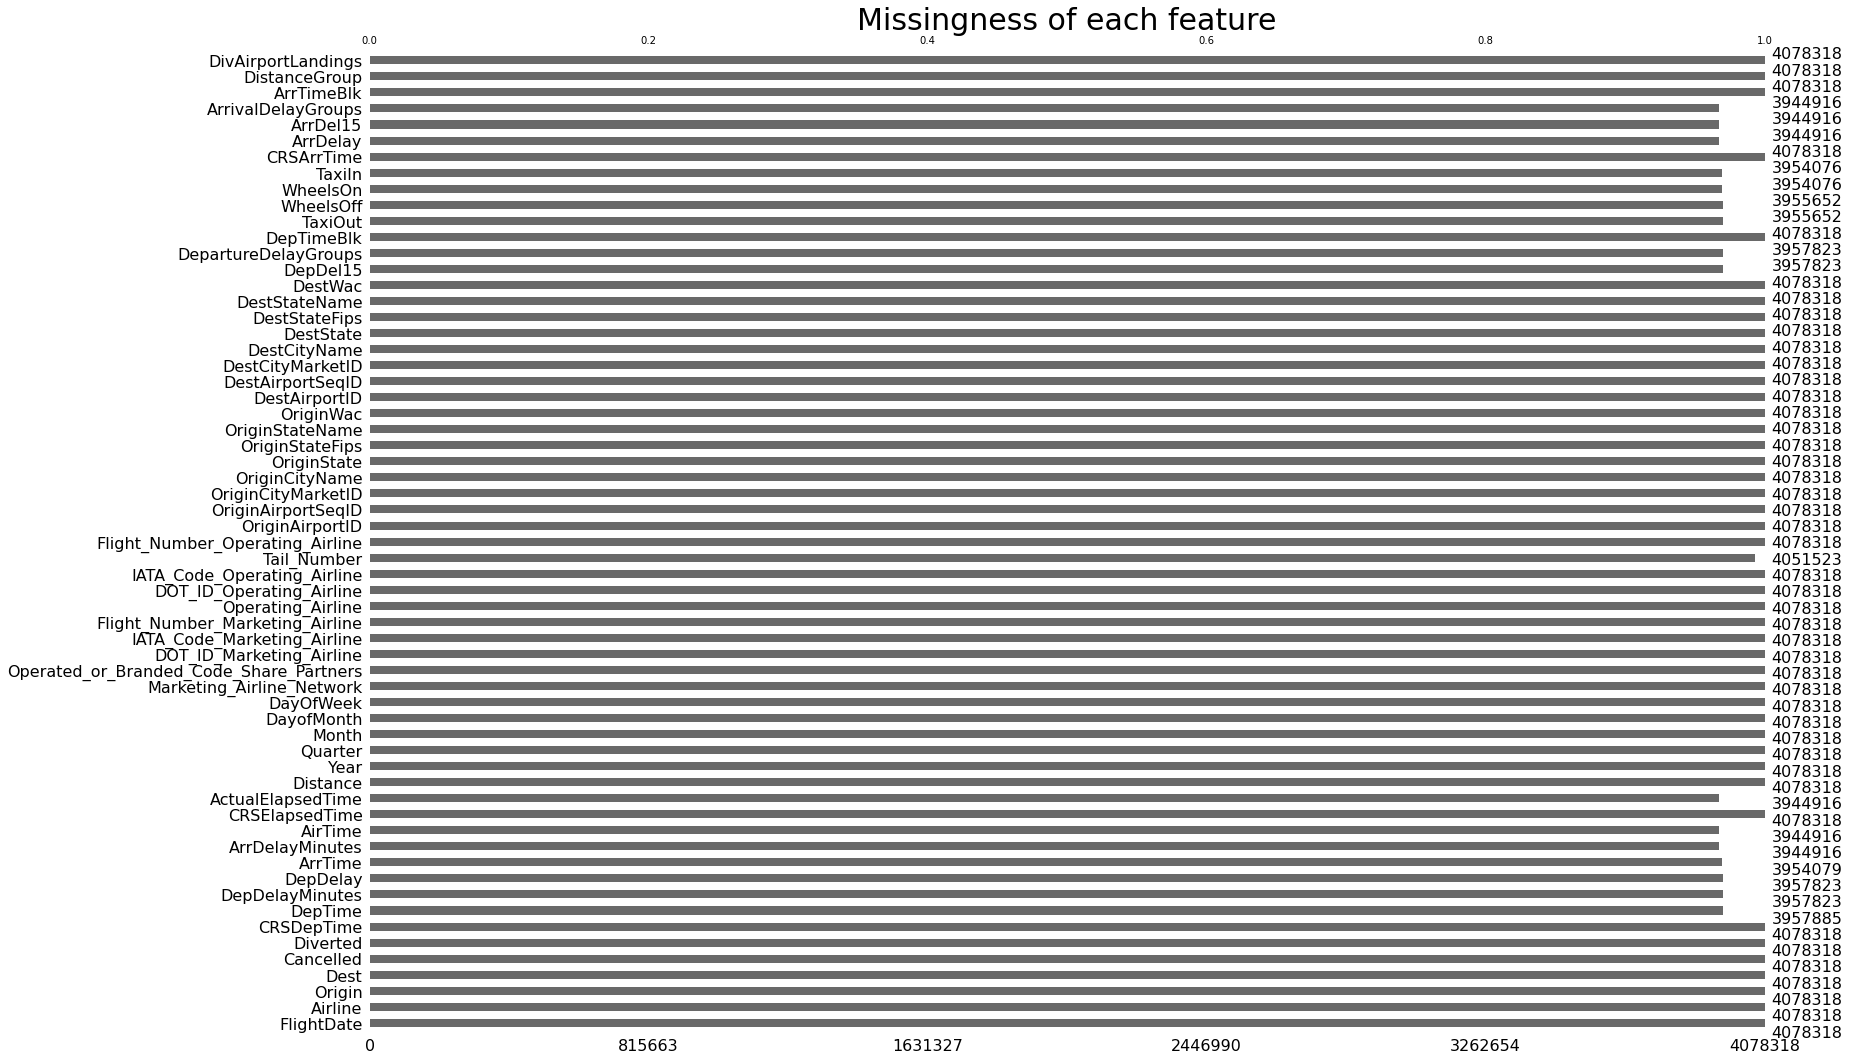

In [7]:
msno.bar(flights)
plt.title('Missingness of each feature', fontsize=30)
plt.show()

The missing data is Not Missing At Random (NMAR) since we couldn't get the data if the flight was cancelled.

In [8]:
flights = flights.dropna(axis=1)
flights.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,...,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,72.0,212.0,2022,...,"Denver, CO",CO,8,Colorado,82,1100-1159,1245,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,77.0,295.0,2022,...,"Houston, TX",TX,48,Texas,74,0700-0759,849,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,70.0,251.0,2022,...,"Denver, CO",CO,8,Colorado,82,1500-1559,1639,1600-1659,2,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,90.0,376.0,2022,...,"Gulfport/Biloxi, MS",MS,28,Mississippi,53,1400-1459,1605,1600-1659,2,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,70.0,251.0,2022,...,"Denver, CO",CO,8,Colorado,82,1100-1159,1245,1200-1259,2,0


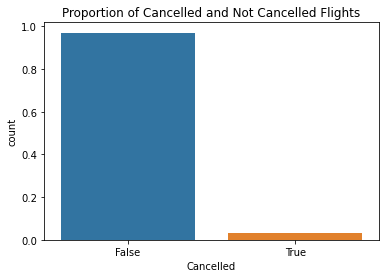

In [9]:
prop_counts = pd.DataFrame(flights['Cancelled'].value_counts() / flights.shape[0]).reset_index()
sns.barplot(x='Cancelled', y='count', data=prop_counts)
plt.title("Proportion of Cancelled and Not Cancelled Flights")
plt.show()

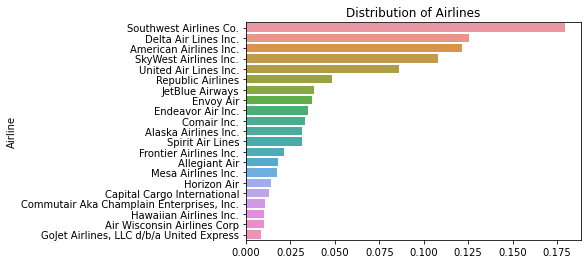

In [10]:
airline_proportions = flights['Airline'].value_counts(normalize=True)
sns.barplot(x=airline_proportions.values, y=airline_proportions.index)
plt.title('Distribution of Airlines')
plt.show()

Distributions for the flight distance and duration of all flights. Both distributions are skewed to the right.

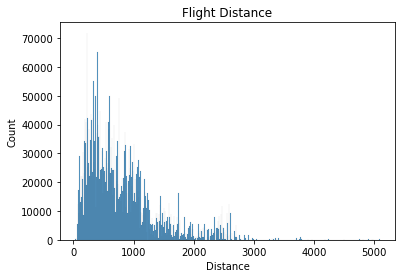

In [11]:
sns.histplot(data=flights, x='Distance')
plt.title('Flight Distance')
plt.show()

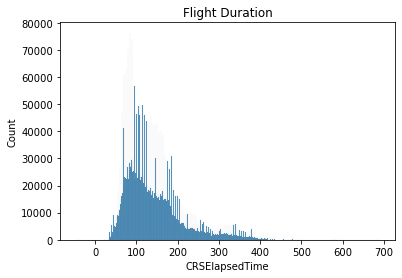

In [12]:
sns.histplot(data=flights,x='CRSElapsedTime')
plt.title("Flight Duration")
plt.show()

# Baseline Model - Proportions

In [13]:
flights_train, flights_test = train_test_split(flights[['Origin', 'Cancelled']], test_size=0.2)

We can find the proportion of all cancelled flights.

In [14]:
prop_cancelled = flights_train['Cancelled'].value_counts(normalize=True)[True]
prop_cancelled

0.03015826992381049

We see that some flight origins produce a higher proportion of cancelled flights than the total while others produce less.

In [15]:
cancelled = pd.DataFrame(flights_train.groupby('Origin')['Cancelled'].mean()).sort_values('Cancelled', ascending=False)
cancelled

,Cancelled
Origin,
PIR,0.333333
JMS,0.122353
CMX,0.116923
LAR,0.115108
DVL,0.114907
...,...
WYS,0.000000
PPG,0.000000
ATY,0.000000


We can set our baseline model to the following: When the flight comes from an origin that produces more than the average cancelled flights, predict it as cancelled. Otherwise predict it as not cancelled.

In [16]:
likely_to_cancel = set(cancelled[cancelled['Cancelled'] >= prop_cancelled].index)

def predict(origin):
    return origin not in likely_to_cancel

flights_test['Prediction'] = flights_test['Origin'].apply(predict)
flights_test.head()

,Origin,Cancelled,Prediction
3113963,LAS,False,True
72295,PHX,False,True
4015769,DAL,False,False
3408093,PAH,False,False
3968667,HOU,False,True


In [17]:
cr_baseline = classification_report(flights_test['Cancelled'], flights_test['Prediction'])
print(cr_baseline)

              precision    recall  f1-score   support

       False       0.96      0.48      0.64    790868
        True       0.02      0.34      0.04     24796

    accuracy                           0.48    815664
   macro avg       0.49      0.41      0.34    815664
weighted avg       0.93      0.48      0.62    815664



We get an accuracy of 0.47 which is about half. We can improve this amount with a better model next.

# Baseline Model - Decision Tree

In [18]:
cancelled_df = flights[flights['Cancelled'] == True]
not_cancelled_df = flights[flights['Cancelled'] == False]

In [19]:
cancelled_subset = cancelled_df.sample(100000)
not_cancelled_subset = not_cancelled_df.sample(300000)
flights_subset = pd.concat([cancelled_subset, not_cancelled_subset])
flights_subset = flights_subset.sample(frac=1)

In [20]:
X = flights[['Airline', 'Origin', 'Dest', 'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek']]
y = flights['Cancelled']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
categorical = ['Airline', 'Origin', 'Dest']

In [23]:
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

In [24]:
model = tree.DecisionTreeClassifier(max_depth=200, max_features=175, max_leaf_nodes=18, class_weight='balanced')
pipeline = Pipeline(steps=[
    
    ('preprocess', preprocessor),
    ('tree', model)
])

In [25]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Origin',
                                                   'Dest'])])),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=200,
                                        max_features=175, max_leaf_nodes=18))])

In [26]:
preds_test = pipeline.predict(X_test)
decision_tree = classification_report(preds_test, y_test)

# Baseline Model - Logistic Regression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(flights[['Airline','Origin', 'Dest']], flights['Cancelled'],test_size=0.2)

In [28]:
col_trans = ColumnTransformer(transformers = [('one_hot', OneHotEncoder(handle_unknown='ignore'), ['Airline', 'Origin', 'Dest'])])

improved_baseline = Pipeline([('trans', col_trans), ('dt', linear_model.LogisticRegression(n_jobs = 8))])
improved_baseline.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Origin',
                                                   'Dest'])])),
                ('dt', LogisticRegression(n_jobs=8))])

In [29]:
improved_baseline.score(X_test, y_test)

0.9699484101296613

In [30]:
cr_baseline_log = classification_report(y_test, improved_baseline.predict(X_test), zero_division=0)
print(cr_baseline_log)

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    791152
        True       0.00      0.00      0.00     24512

    accuracy                           0.97    815664
   macro avg       0.48      0.50      0.49    815664
weighted avg       0.94      0.97      0.96    815664



# Improved Model - Latent Factor Model

In [31]:
cancelled_df = flights[flights['Cancelled'] == True]
not_cancelled_df = flights[flights['Cancelled'] == False]

In [32]:
cancelled_subset = cancelled_df.sample(100000)
not_cancelled_subset = not_cancelled_df.sample(300000)
flights_subset = pd.concat([cancelled_subset, not_cancelled_subset])
flights_subset = flights_subset.sample(frac=1)

In [33]:
prop_cancelled = flights_subset['Cancelled'].value_counts(normalize=True)[True]

In [34]:
interactions = flights_subset[['Airline', 'Origin', 'Cancelled']].to_numpy()

In [35]:
userIDs,itemIDs = {},{}

for d in interactions:
    u,i = d[0],d[1]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i,r in interactions:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)
    
items = list(itemIDs.keys())

In [36]:
mu = sum([r for _,_,r in interactions]) / len(interactions)

In [37]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2) +\
                            tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [38]:
def trainingStep(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [39]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelLFM = LatentFactorModel(mu, 100, 0.00001)

In [40]:
for i in range(100):
    obj = trainingStep(modelLFM, interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.10071396
iteration 20, objective = 0.0957557
iteration 30, objective = 0.09203023
iteration 40, objective = 0.09091132
iteration 50, objective = 0.0903112
iteration 60, objective = 0.09036685
iteration 70, objective = 0.0900651
iteration 80, objective = 0.089807525
iteration 90, objective = 0.08960697
iteration 100, objective = 0.090019904


In [41]:
def oid(x):
    if x in itemIDs:
        return itemIDs[x]
    else:
        return np.nan

In [42]:
test_data = pd.concat([cancelled_df.sample(10000), not_cancelled_df.sample(30000)])
test_data = test_data[['Airline', 'Origin', 'Cancelled']]
test_data['AirlineID'] = test_data['Airline'].apply(lambda x: userIDs[x])
test_data['OriginID'] = test_data['Origin'].apply(oid)
test_data = test_data.dropna()
test_data

,Airline,Origin,Cancelled,AirlineID,OriginID
3364329,SkyWest Airlines Inc.,RIW,True,8,218
3000318,Frontier Airlines Inc.,TTN,True,18,185
3288792,American Airlines Inc.,PHL,True,9,42
3068609,Comair Inc.,PVD,True,3,153
3086008,Southwest Airlines Co.,MCO,True,1,30
...,...,...,...,...,...
2247440,Southwest Airlines Co.,BWI,False,1,74
2239034,Southwest Airlines Co.,ATL,False,1,11
2553599,Allegiant Air,BWI,False,12,74
922018,Hawaiian Airlines Inc.,SFO,False,10,0


In [43]:
preds = modelLFM.predictSample(test_data['AirlineID'], test_data['OriginID'])
test_data['score'] = preds
test_data['prediction'] = test_data['score'] > 0.40
test_data.sort_values('Cancelled')

,Airline,Origin,Cancelled,AirlineID,OriginID,score,prediction
2584845,Envoy Air,DFW,False,4,5,0.238222,False
2919002,Delta Air Lines Inc.,CLT,False,5,14,0.105743,False
1437960,American Airlines Inc.,MIA,False,9,37,0.327399,False
2834715,American Airlines Inc.,CMH,False,9,82,0.258129,False
1382936,Spirit Air Lines,SJU,False,17,9,0.229128,False
...,...,...,...,...,...,...,...
41043,Southwest Airlines Co.,HOU,True,1,98,0.192564,False
3232755,American Airlines Inc.,ALB,True,9,88,0.354765,False
2816585,American Airlines Inc.,TPA,True,9,53,0.293380,False
1472627,American Airlines Inc.,LGA,True,9,29,0.442715,True


In [44]:
cr_lfm = classification_report(test_data['Cancelled'], test_data['prediction'])
print(cr_lfm)

              precision    recall  f1-score   support

       False       0.77      0.94      0.84     30000
        True       0.44      0.15      0.23     10000

    accuracy                           0.74     40000
   macro avg       0.61      0.54      0.54     40000
weighted avg       0.69      0.74      0.69     40000



# Improved Model - Logistic Regression

In [45]:
cols = ['Airline','Origin', 'Dest', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'DistanceGroup', 'CRSDepTime']

In [46]:
cancelled_subset = cancelled_df.sample(100000)
not_cancelled_subset = not_cancelled_df.sample(300000)
flights_subset = pd.concat([cancelled_subset, not_cancelled_subset])
flights_subset = flights_subset.sample(frac=1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(flights_subset[cols], flights_subset['Cancelled'],test_size=0.2)

In [48]:
one_hot_cols = ['Airline', 'Origin', 'Dest', 'Month', 'DayofMonth', 'DayOfWeek', 'DistanceGroup']

In [49]:
col_trans = ColumnTransformer(transformers = [('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)])

mdl = Pipeline([('trans', col_trans), ('dt', linear_model.LogisticRegression())])
# mdl.fit(X_train, y_train)

In [50]:
cv = GridSearchCV(mdl, param_grid={'dt__C':[0.001, 0.1, 1, 10, 100], 'dt__n_jobs':[8], 'dt__class_weight': ['balanced']})
cv.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Airline',
                                                                          'Origin',
                                                                          'Dest',
                                                                          'Month',
                                                                          'DayofMonth',
                                                                          'DayOfWeek',
                                                                          'DistanceGroup'])])),
                                       ('dt', LogisticRegression())]),
             param_grid={'dt__C': [0.001, 0.1, 1, 10, 100],
                  

In [51]:
log_reg = cv.best_estimator_
preds = log_reg.predict(X_test)
cr_log_improved = classification_report(y_test, preds)
print(cr_log_improved)

              precision    recall  f1-score   support

       False       0.87      0.69      0.77     60070
        True       0.42      0.68      0.52     19930

    accuracy                           0.69     80000
   macro avg       0.65      0.69      0.65     80000
weighted avg       0.76      0.69      0.71     80000



# Improved Model - Random Forest

In [52]:
cancelled_subset = cancelled_df.sample(100000)
not_cancelled_subset = not_cancelled_df.sample(300000)
flights_subset = pd.concat([cancelled_subset, not_cancelled_subset])
flights_subset = flights_subset.sample(frac=1)

In [53]:
forest = Pipeline([('trans', col_trans), ('dt', RandomForestClassifier(
    n_estimators=150, 
    max_depth=1000, 
    n_jobs=8,
    max_features='sqrt',
    class_weight='balanced',
    random_state=1
))])
forest.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Origin', 'Dest',
                                                   'Month', 'DayofMonth',
                                                   'DayOfWeek',
                                                   'DistanceGroup'])])),
                ('dt',
                 RandomForestClassifier(class_weight='balanced', max_depth=1000,
                                        max_features='sqrt', n_estimators=150,
                                        n_jobs=8, random_state=1))])

In [54]:
preds = forest.predict(X_test)
cr_forest = classification_report(y_test, preds)
print(cr_forest)

              precision    recall  f1-score   support

       False       0.88      0.92      0.90     60070
        True       0.71      0.61      0.66     19930

    accuracy                           0.84     80000
   macro avg       0.80      0.76      0.78     80000
weighted avg       0.84      0.84      0.84     80000



# All Outputs

### Baseline

In [55]:
print(cr_baseline)

              precision    recall  f1-score   support

       False       0.96      0.48      0.64    790868
        True       0.02      0.34      0.04     24796

    accuracy                           0.48    815664
   macro avg       0.49      0.41      0.34    815664
weighted avg       0.93      0.48      0.62    815664



### Decision Tree - Baseline

In [56]:
print(decision_tree)

              precision    recall  f1-score   support

       False       0.69      0.80      0.74     52513
        True       0.46      0.33      0.39     27487

    accuracy                           0.64     80000
   macro avg       0.58      0.56      0.56     80000
weighted avg       0.61      0.64      0.62     80000



### Logistic Regression - Baseline

In [57]:
print(cr_baseline_log)

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    791152
        True       0.00      0.00      0.00     24512

    accuracy                           0.97    815664
   macro avg       0.48      0.50      0.49    815664
weighted avg       0.94      0.97      0.96    815664



### Latent Factor Model

In [58]:
print(cr_lfm)

              precision    recall  f1-score   support

       False       0.77      0.94      0.84     30000
        True       0.44      0.15      0.23     10000

    accuracy                           0.74     40000
   macro avg       0.61      0.54      0.54     40000
weighted avg       0.69      0.74      0.69     40000



### Logistic Regression - Improved

In [59]:
print(cr_log_improved)

              precision    recall  f1-score   support

       False       0.87      0.69      0.77     60070
        True       0.42      0.68      0.52     19930

    accuracy                           0.69     80000
   macro avg       0.65      0.69      0.65     80000
weighted avg       0.76      0.69      0.71     80000



### Random Forest

In [60]:
print(cr_forest)

              precision    recall  f1-score   support

       False       0.88      0.92      0.90     60070
        True       0.71      0.61      0.66     19930

    accuracy                           0.84     80000
   macro avg       0.80      0.76      0.78     80000
weighted avg       0.84      0.84      0.84     80000

